# 3 Online Monitoring within Notebook


### Prerequisite: FFmpeg - decoding mpeg 

* 1 download FFmpeg:http://ffmpeg.zeranoe.com/builds/,unzip to location dir 
 
* 2 set **ffmpeg** location dir to windows path

## Monitoring the Generator Power 

In [1]:
# -*- coding: utf-8 -*-

import redis

conn = redis.Redis('localhost')

def tagvalue_redis(taglist):
     
    tagcount=len(taglist)
    pipe = conn.pipeline()
        
    for i in range(tagcount):
        pipe.hmget(taglist[i]['id'], 'value')
    tagvaluelist = pipe.execute()

    for i in range(tagcount):
        taglist[i]['value'] = tagvaluelist[i][0].decode()
            
unittaglist=[]
# the Generator Power 
unittaglist.append({'id':"CSDC.DCS2AI.2JZA2871"})  

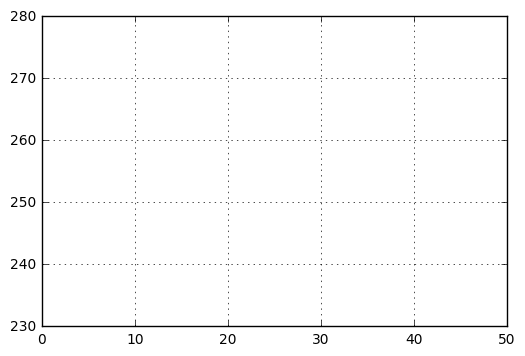

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.grid()
ax.set_xlim((0,50))
ax.set_ylim((230,280))
line, = ax.plot([], [],'o-')

idx, power = [], []

# initialization function: plot the background of each frame
def init():
    line.set_data(idx,power)
    return (line,)

# monitor function. This is called sequentially
def monitor(i):
    tagvalue_redis(unittaglist)
    curpower=unittaglist[0]['value']
    idx.append(i)
    power.append(curpower)
    
    xmin, xmax = ax.get_xlim()

    if i >= xmax:
        idx.pop(0)
        power.pop(0)
        
        ax.set_xlim(i-50, i)
        ax.figure.canvas.draw()
   
    line.set_data(idx,power)
    return (line,)

# call the monitor. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, monitor, init_func=init,
                               frames=100, interval=2000, blit=True)
plt.show()

In [3]:
HTML(anim.to_html5_video())

In [1]:
##github.com/jupyter/ngcm-tutorial/blob/master/Day-1/IPython%20Kernel/Background%20Jobs.ipynb
from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()

def printfunc(interval=1, reps=5):
    for n in range(reps):
        time.sleep(interval)
        print('In the background... %i' % n)
        sys.stdout.flush()
    print('All done!')
    sys.stdout.flush()

jobs.new('printfunc(1,3)')
jobs.status()

Starting job # 0 in a separate thread.
Dead jobs:
0 : printfunc(1,3)



In [2]:
from IPython.display import display
from ipywidgets import IntProgress

import threading

class App(object):
    def __init__(self, nloops=2000):
        self.nloops = nloops
        self.pb = IntProgress(description='Thread loops', min=0, max=self.nloops)

    def start(self):
        display(self.pb)
        while self.pb.value < self.nloops:
            self.pb.value += 1 
        self.pb.color = 'red'

app = App(nloops=20000)

t = threading.Thread(target=app.start)

t.start()
#t.join()

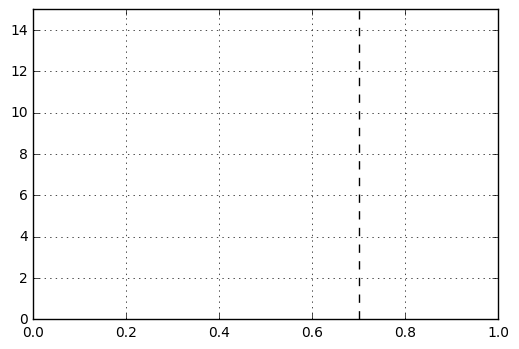

In [3]:
# update a distribution based on new data.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from matplotlib.animation import FuncAnimation

from IPython.display import HTML


class UpdateDist(object):
    def __init__(self, ax, prob=0.5):
        self.success = 0
        self.prob = prob
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 15)
        self.ax.grid(True)

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(prob, linestyle='--', color='black')

    def init(self):
        self.success = 0
        self.line.set_data([], [])
        return self.line,

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            return self.init()

        # Choose success based on exceed a threshold with a uniform pick
        if np.random.rand(1,) < self.prob:
            self.success += 1
        y = ss.beta.pdf(self.x, self.success + 1, (i - self.success) + 1)
        self.line.set_data(self.x, y)
        return self.line,

fig, ax = plt.subplots()
ud = UpdateDist(ax, prob=0.7)
anim = FuncAnimation(fig, ud, frames=np.arange(100), init_func=ud.init,
                     interval=100, blit=True)
plt.show()

In [4]:
HTML(anim.to_html5_video())